## Imports and Setup

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import umap.umap_ as umap

## Load Data

In [17]:
X = pd.read_csv("data/X_gexp.csv", index_col=0)  # 5000 features
y = pd.read_csv("data/y_gexp.csv", index_col=0).values.ravel()  # 0=Classical, 1=Mesenchymal

In [18]:
print("Data shape:", X.shape)
print("Labels shape:", y.shape)

Data shape: (302, 5000)
Labels shape: (302,)


## Standarize Features

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## PCA Visualization

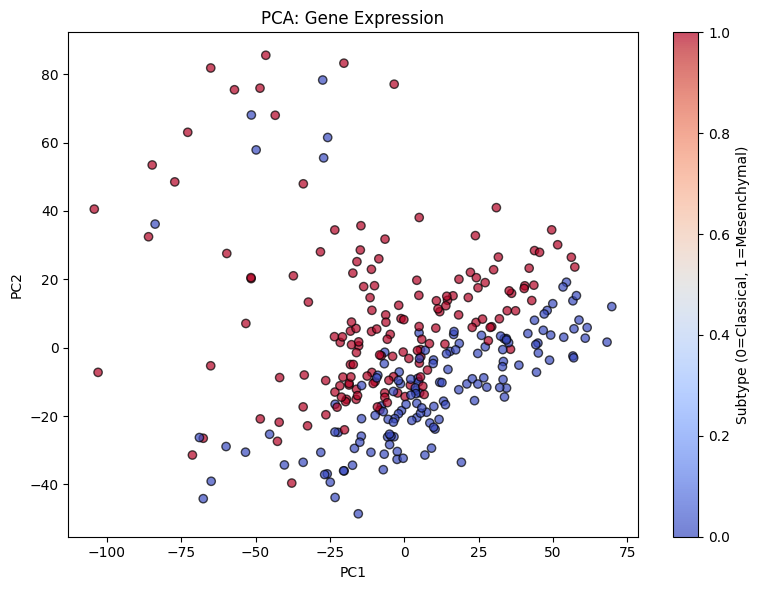

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: Gene Expression")
plt.colorbar(label="Subtype (0=Classical, 1=Mesenchymal)")
plt.tight_layout()
plt.show()

## UMAP Visualization

c:\Users\mathe\anaconda3\envs\bioinf\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\bioinf\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


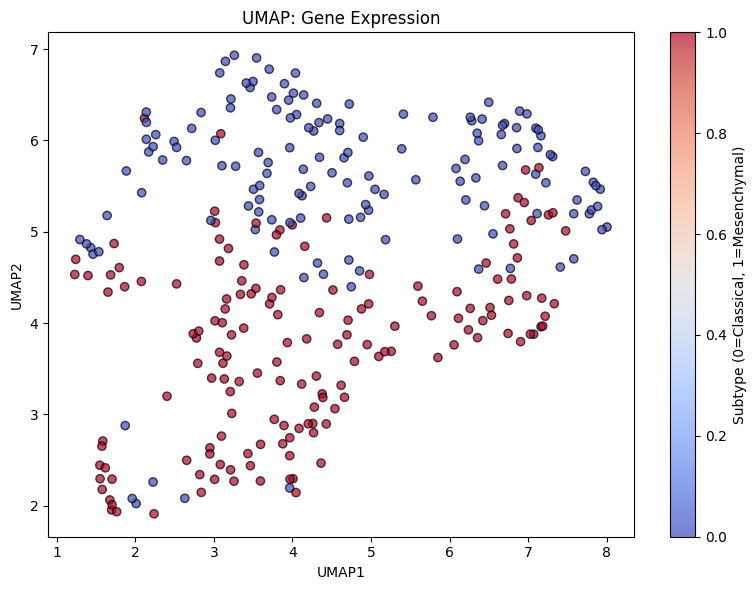

In [21]:
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP: Gene Expression")
plt.colorbar(label="Subtype (0=Classical, 1=Mesenchymal)")
plt.tight_layout()
plt.show()

## K-Means Clustering

K-means ARI: 0.045


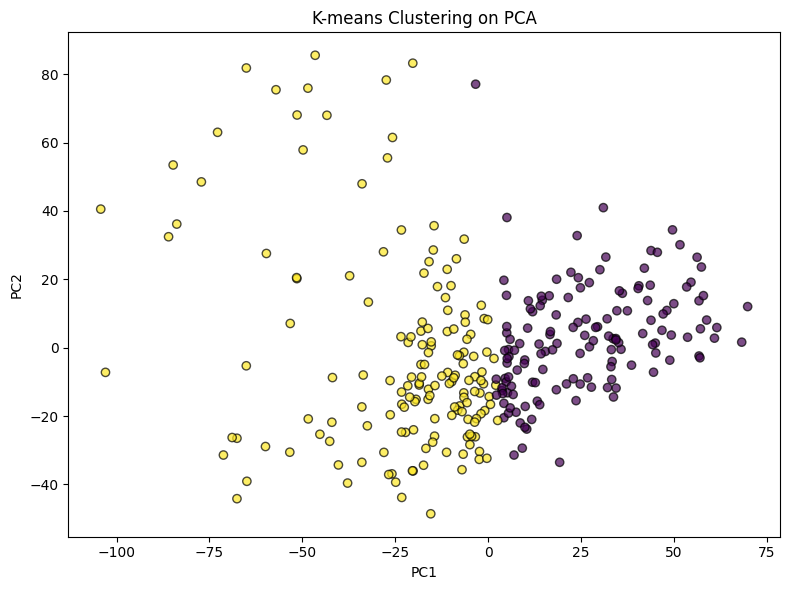

In [22]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)

ari_kmeans = adjusted_rand_score(y, clusters_kmeans)
print(f"K-means ARI: {ari_kmeans:.3f}")

# Visualize clusters on PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("K-means Clustering on PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

## Hierarchical Clustering

Hierarchical Clustering ARI: 0.002


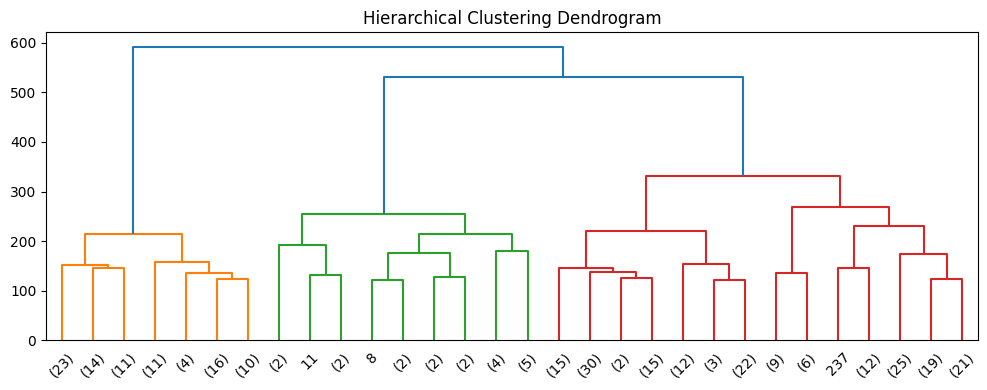

In [23]:
Z = linkage(X_scaled, method='ward')
clusters_hier = fcluster(Z, t=2, criterion='maxclust') - 1  # convert to 0/1

ari_hier = adjusted_rand_score(y, clusters_hier)
print(f"Hierarchical Clustering ARI: {ari_hier:.3f}")

# Dendrogram (optional)
plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode="lastp", p=30)
plt.title("Hierarchical Clustering Dendrogram")
plt.tight_layout()
plt.show()

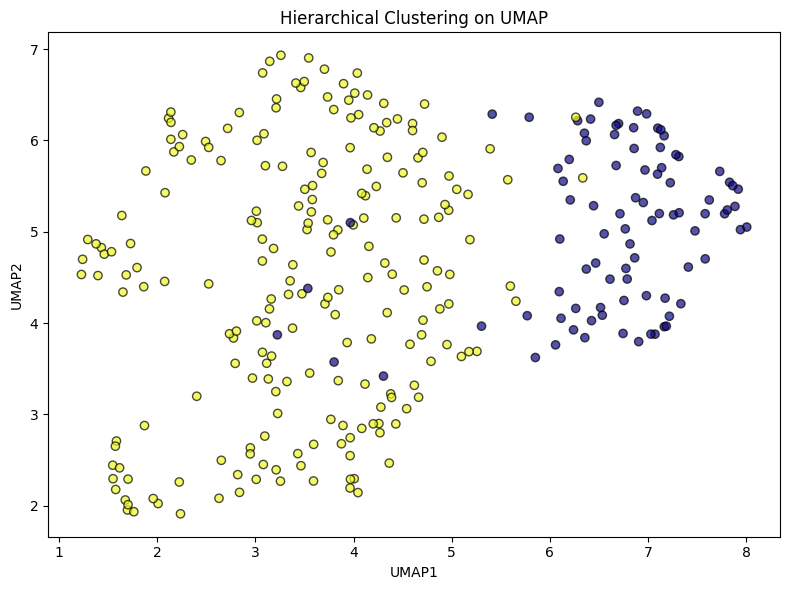

In [24]:
# Visualize hierarchical clusters on UMAP
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters_hier, cmap='plasma', edgecolor='k', alpha=0.7)
plt.title("Hierarchical Clustering on UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

## Supervised Learning

In [25]:
# -----------------------------
# Configuration
# -----------------------------
K_FOLDS = 4
N_FEATURES = 100  # can be tuned

In [26]:
# Storage for results
results = {
    "SVM": {"accuracy": [], "precision": [], "recall": [], "f1": []},
    "RF":  {"accuracy": [], "precision": [], "recall": [], "f1": []}
}

## Cross-Validation Pipeline

In [27]:
cv = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    print(f"Fold {fold + 1}")
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Preprocessing ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- Feature Selection ---
    selector = SelectKBest(score_func=f_classif, k=N_FEATURES)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    # --- SVM ---
    svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred_svm = svm.predict(X_test_selected)

    # --- Random Forest ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_selected, y_train)
    y_pred_rf = rf.predict(X_test_selected)

    # --- Metrics ---
    for model_name, y_pred in zip(["SVM", "RF"], [y_pred_svm, y_pred_rf]):
        results[model_name]["accuracy"].append(accuracy_score(y_test, y_pred))
        results[model_name]["precision"].append(precision_score(y_test, y_pred))
        results[model_name]["recall"].append(recall_score(y_test, y_pred))
        results[model_name]["f1"].append(f1_score(y_test, y_pred))

Fold 1
Fold 2
Fold 3
Fold 4


## Summary Results

In [28]:
def summarize(metric_list):
    mean = np.mean(metric_list)
    std = np.std(metric_list)
    return f"{mean:.3f} ± {std:.3f}"

print("\n=== Model Performance (mean ± std over folds) ===")
for model_name in results:
    print(f"\n{model_name}")
    for metric in results[model_name]:
        print(f"{metric.capitalize()}: {summarize(results[model_name][metric])}")


=== Model Performance (mean ± std over folds) ===

SVM
Accuracy: 0.911 ± 0.044
Precision: 0.891 ± 0.029
Recall: 0.942 ± 0.064
F1: 0.915 ± 0.044

RF
Accuracy: 0.904 ± 0.018
Precision: 0.891 ± 0.017
Recall: 0.929 ± 0.046
F1: 0.909 ± 0.019
